


=========================================== Descriptive Statistics for X ===========================================
The descriptive statistics provide a summary of the central tendency, dispersion, and shape of the distribution of data.
Here are the key values and their interpretations:
 ~ count: Number of non-missing observations in the dataset.
 ~ mean: Average value of the data.
 ~ std: Standard deviation, which measures the dispersion of data points around the mean.
 ~ min: Minimum value in the dataset.
 ~ 25%: Lower quartile or first quartile, representing the value below which 25% of the data fall.
 ~ 50%: Median or second quartile, representing the middle value of the dataset.
 ~ 75%: Upper quartile or third quartile, representing the value below which 75% of the data fall.
 ~ max: Maximum value in the dataset.
Interpretation: These statistics help understand the distribution of the data and identify any outliers or skewness.
For example, a large standard deviation indicates

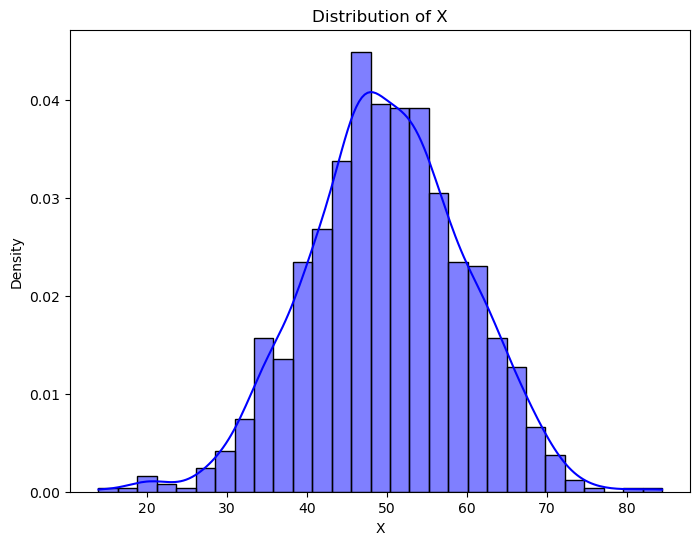

c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)





=========================================== Goodness-of-Fit Test Results for X ===========================================
Distribution    Parameters                     D-Statistic     P-Value        
norm            49.9, 9.8                      0.018           0.886          
expon           14.0, 35.9                     0.383           0.000          
gamma           890.6, -241.8, 0.3             0.022           0.730          
lognorm         0.0, -862.6, 912.5             0.018           0.891          
beta            2058759.2, 430.7, -968039.8, 968292.2 0.017           0.930          
johnsonsu       1.0, 5.9, 59.3, 55.6           0.018           0.909          
weibull_min     4.6, 9.5, 44.2                 0.025           0.532          



===================================================== Q-Q Plot =====================================================
A Q-Q plot (quantile-quantile plot) is a graphical method for comparing two probability distributions by plotting
t

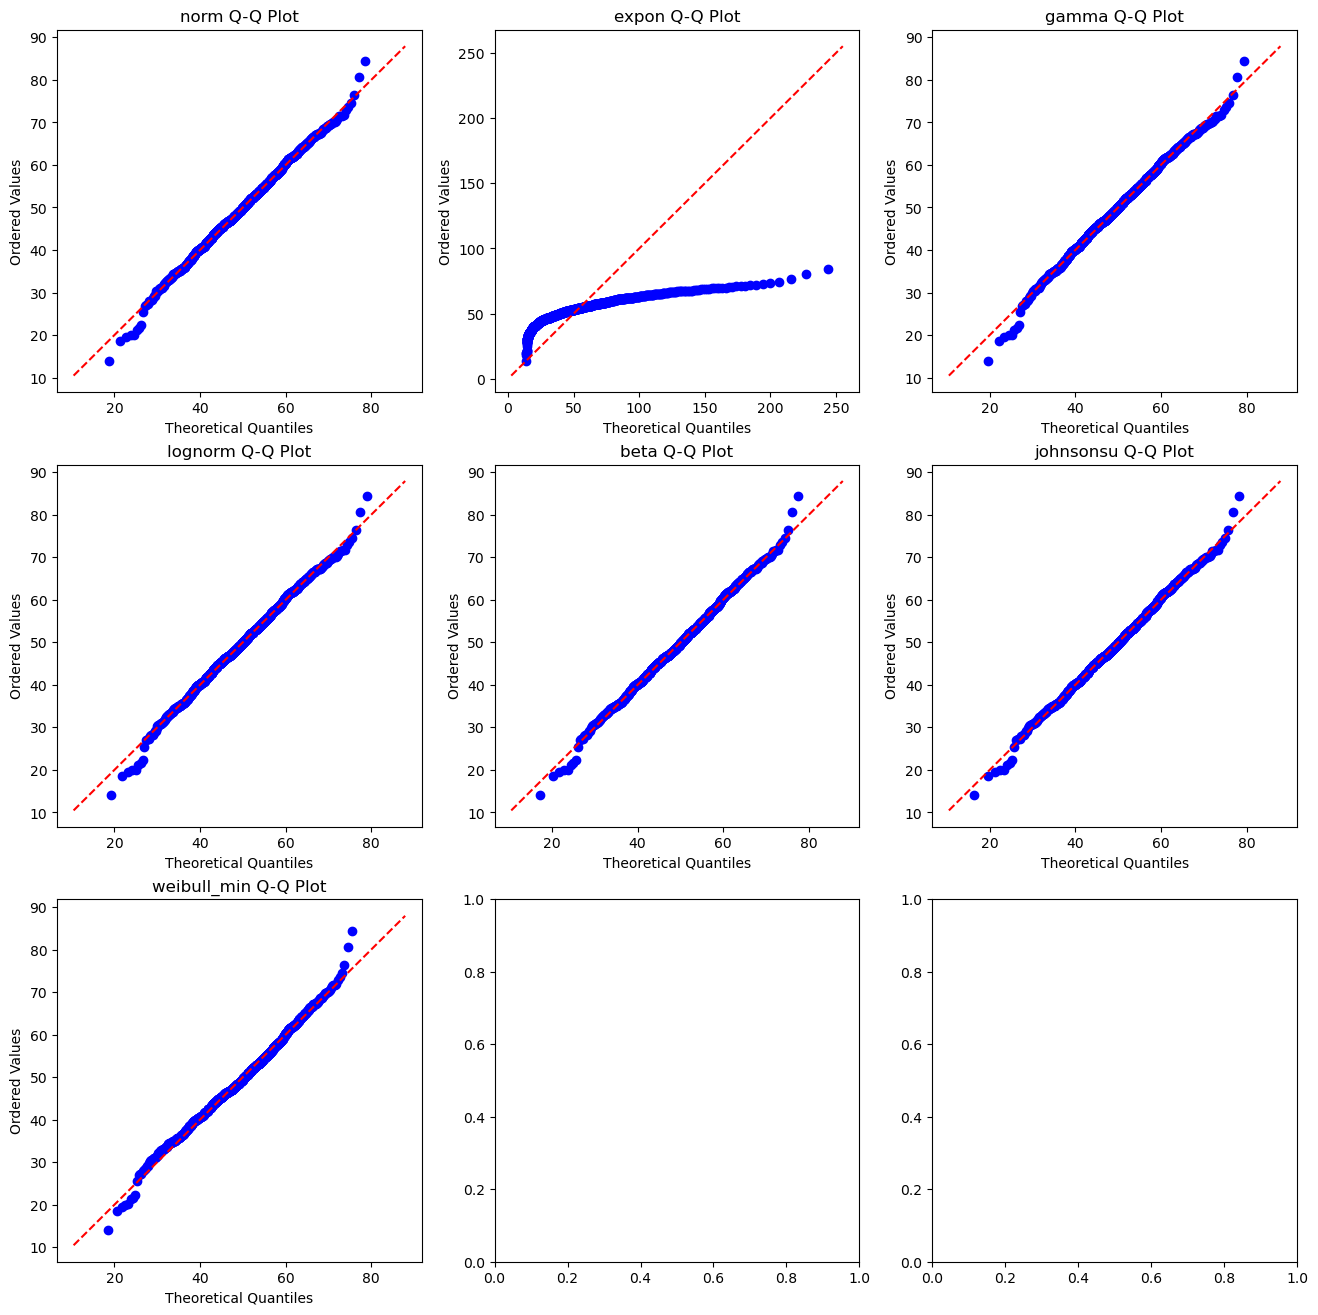

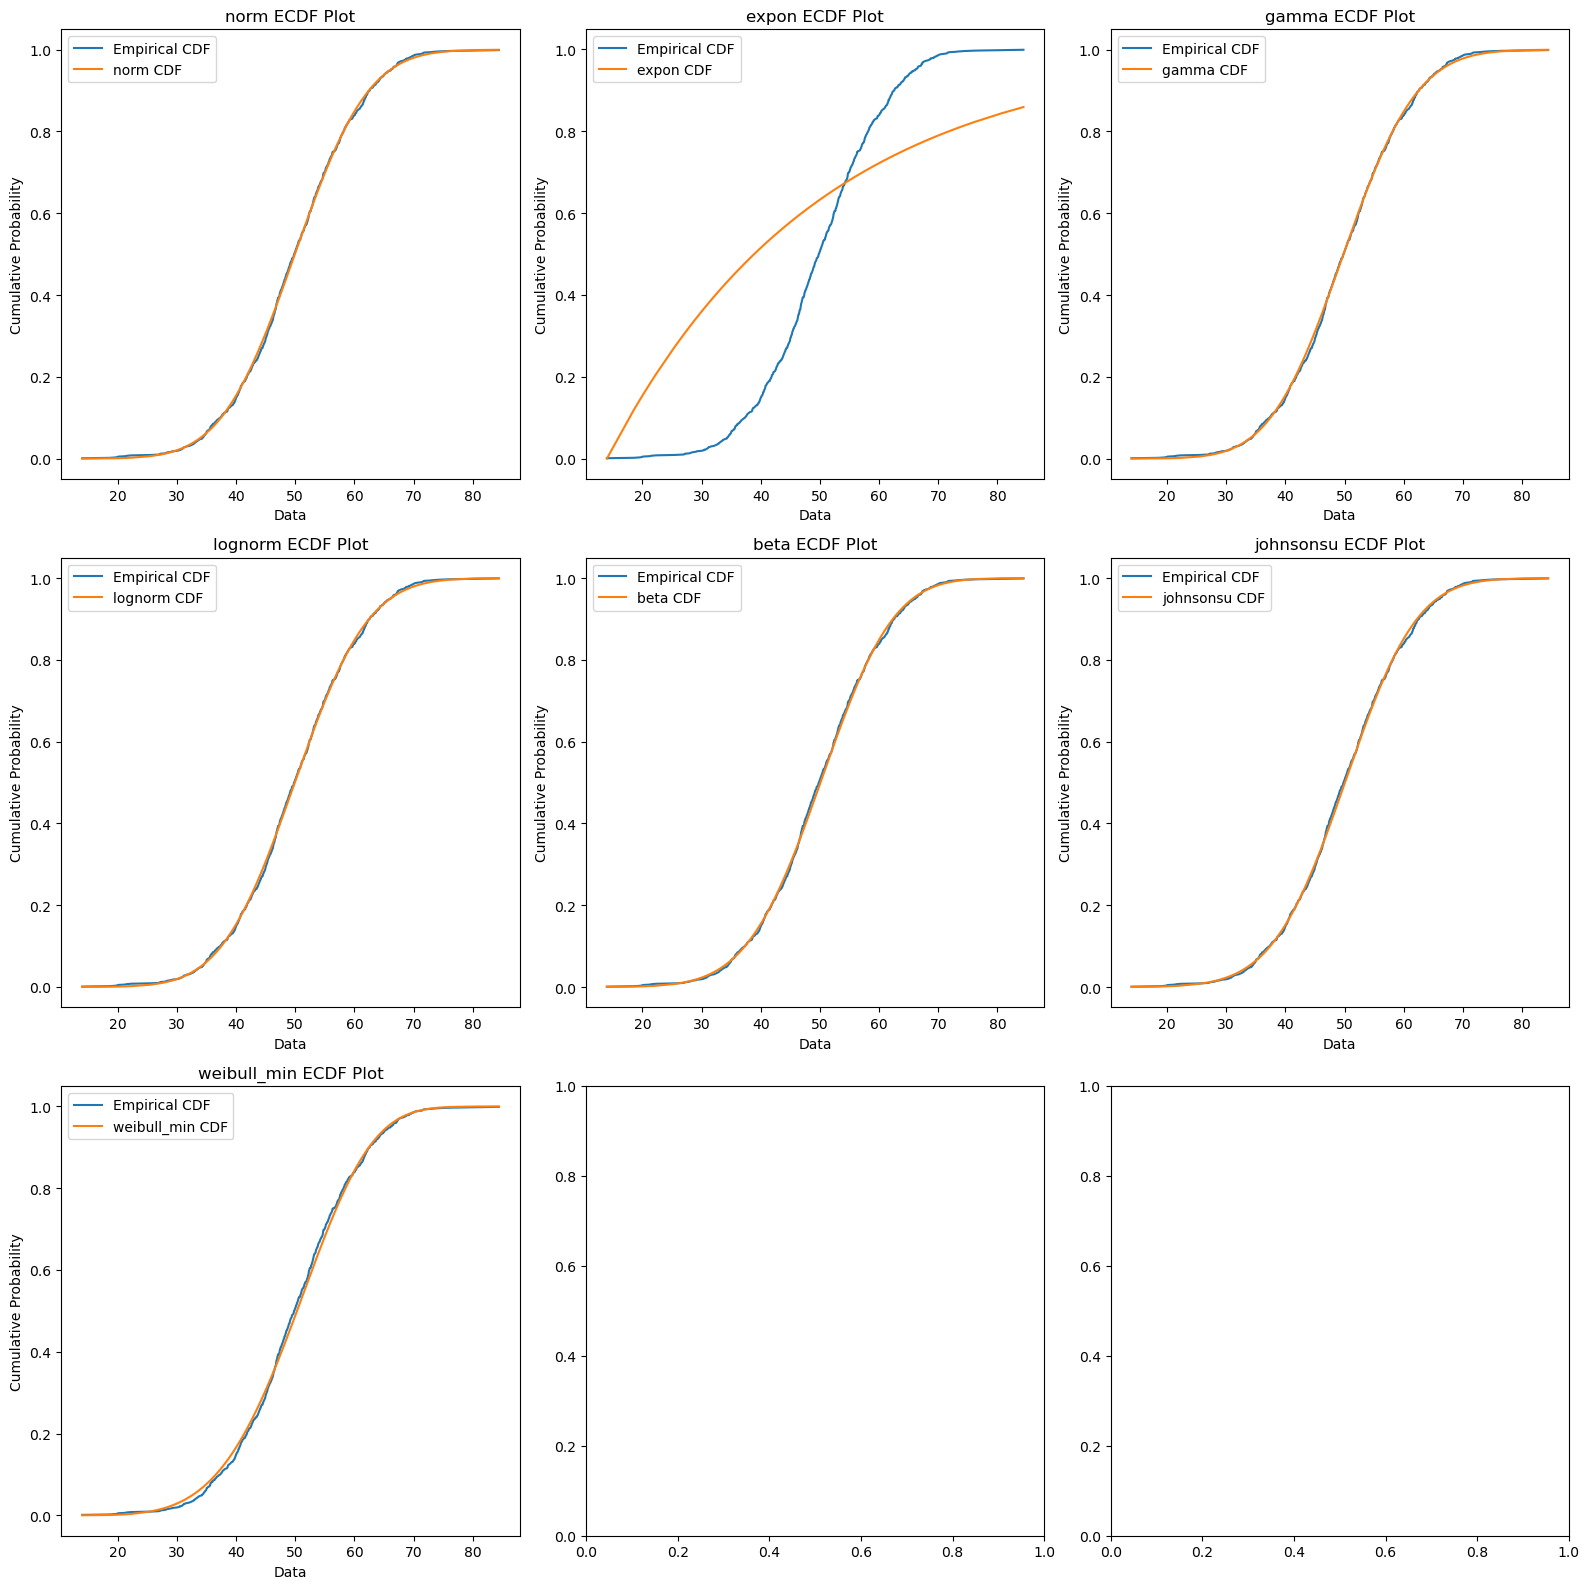

In [3]:
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import filedialog, ttk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Global variables
df = None
columns = None
window = None

# Read Excel file
def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        global df, columns
        df = pd.read_excel(file_path)  # Read Excel file into a DataFrame
        columns = df.columns.tolist()  # Get column names
        return df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None

def plot_histogram(column):
    """Plots histogram for the selected column."""
    try:
        # Plot distribution
        plt.figure(figsize=(8, 6))
        sns.histplot(df[column], kde=True, color='blue', stat='density')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        plt.show()
    except Exception as e:
        print(f"Error plotting histogram: {e}")

def plot_qq_plot(data, dist, params, ax):
    """Plot Q-Q plot for a given distribution."""
    # Generate sorted data for Q-Q plot
    sorted_data = np.sort(data)

    # Plot Q-Q plot
    stats.probplot(data, dist=dist, sparams=params, plot=ax)
    ax.set_title(f'{dist.name} Q-Q Plot')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Ordered Values')

    # Add a line representing the theoretical quantiles
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    min_val = min(xmin, ymin)
    max_val = max(xmax, ymax)
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')


def plot_ecdf(data, dist, params, ax):
    """Plot ECDF for a given distribution."""
    # Generate sorted data for ECDF
    sorted_data = np.sort(data)

    # Plot ECDF
    ax.plot(sorted_data, np.arange(1, len(sorted_data) + 1) / len(sorted_data), label='Empirical CDF')
    if dist.name == 'boxcox':
        cdf = stats.norm.cdf(sorted_data, *params)
    else:
        cdf = dist.cdf(sorted_data, *params[:-2], loc=params[-2], scale=params[-1])
    ax.plot(sorted_data, cdf, label=f'{dist.name} CDF')
    ax.set_title(f'{dist.name} ECDF Plot')
    ax.set_xlabel('Data')
    ax.set_ylabel('Cumulative Probability')
    ax.legend()

def fit_distributions(column):
    """Fits common distributions to the selected column and evaluates goodness-of-fit."""
    try:
        data = df[column].dropna()

        # Fit common distributions including Johnson transformation
        distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta', 'johnsonsu', 'weibull_min']
        results = {}

        for dist_name in distributions:
            if dist_name == 'johnsonsu':
                params = stats.johnsonsu.fit(data)
                dist = stats.johnsonsu
            elif dist_name == 'weibull_min':
                params = stats.weibull_min.fit(data)
                dist = stats.weibull_min
            elif dist_name == 'boxcox':
                data_transformed, _ = stats.boxcox(data)
                params = tuple()  # Box-Cox has no parameters to fit
                dist = stats.norm  # Box-Cox is often compared with normal distribution
            else:
                dist = getattr(stats, dist_name)
                params = dist.fit(data)

            # Perform Kolmogorov-Smirnov test for goodness-of-fit
            D, p_value = stats.kstest(data, dist_name, args=params)

            results[dist_name] = {'params': params, 'D': D, 'p_value': p_value, 'dist': dist}

        return results
    except Exception as e:
        print(f"Error fitting distributions: {e}")
        return None

def main():
    global df, window

    # Create GUI window
    window = tk.Tk()
    window.title("Distribution Fitting")

    # Open a file dialog to select Excel file
    def open_file_dialog():
        file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
        if file_path:
            # Read Excel file into DataFrame
            df = read_excel_file(file_path)
            if df is not None:
                show_column_selection()

    # Show file selection button
    file_button = tk.Button(window, text="Select Excel File", command=open_file_dialog)
    file_button.pack(pady=20)

    # Function to show column selection
    def show_column_selection():
        # Clear existing widgets
        for widget in window.winfo_children():
            widget.destroy()

        # Label for column selection
        label = tk.Label(window, text="Select Column:")
        label.pack(pady=10)

        # Dropdown for column selection
        global combo
        combo = ttk.Combobox(window, values=columns)
        combo.pack(pady=10)

        # Analyze button
        analyze_button = tk.Button(window, text="Analyze", command=analyze_data)
        analyze_button.pack(pady=10)

    def analyze_data():
        """Callback function to analyze data."""
        # Get selected column
        selected_column = combo.get()

        # Calculate descriptive statistics
        descriptive_stats = df[selected_column].describe()
        
        # Print descriptive statistics
        print(f"\n\n\n=========================================== Descriptive Statistics for {selected_column} ===========================================")
        print("The descriptive statistics provide a summary of the central tendency, dispersion, and shape of the distribution of data.\n"
            "Here are the key values and their interpretations:\n"
            " ~ count: Number of non-missing observations in the dataset.\n"
            " ~ mean: Average value of the data.\n"
            " ~ std: Standard deviation, which measures the dispersion of data points around the mean.\n"
            " ~ min: Minimum value in the dataset.\n"
            " ~ 25%: Lower quartile or first quartile, representing the value below which 25% of the data fall.\n"
            " ~ 50%: Median or second quartile, representing the middle value of the dataset.\n"
            " ~ 75%: Upper quartile or third quartile, representing the value below which 75% of the data fall.\n"
            " ~ max: Maximum value in the dataset.\n"
            "Interpretation: These statistics help understand the distribution of the data and identify any outliers or skewness.\n"
            "For example, a large standard deviation indicates high variability, while a small standard deviation indicates low variability.\n\n")

        print(descriptive_stats)
        
        # Plot histogram
        plot_histogram(selected_column)

        # Fit distributions
        results = fit_distributions(selected_column)
        print("==========================================================================================================================")
        # Print goodness-of-fit test results
        if results:
            print(f"\n\n\n=========================================== Goodness-of-Fit Test Results for {selected_column} ===========================================")
            print("{:<15} {:<30} {:<15} {:<15}".format('Distribution', 'Parameters', 'D-Statistic', 'P-Value'))

            # Create a new figure for Q-Q plots
            fig_qq, axs_qq = plt.subplots(3, 3, figsize=(16, 16))

            # Create a new figure for ECDF plots
            fig_ecdf, axs_ecdf = plt.subplots(3, 3, figsize=(16, 16))

            for i, (dist_name, result) in enumerate(results.items()):
                params_str = ', '.join([f"{param:.1f}" for param in result['params']])
                print("{:<15} {:<30} {:<15.3f} {:<15.3f}".format(dist_name, params_str, result['D'], result['p_value']))

                # Plot Q-Q plot
                plot_qq_plot(df[selected_column], result['dist'], result['params'], axs_qq[i // 3, i % 3])

                # Plot ECDF
                plot_ecdf(df[selected_column], result['dist'], result['params'], axs_ecdf[i // 3, i % 3])
            print("====================================================================================================================")
            
            print("\n\n\n===================================================== Q-Q Plot =====================================================")
            print("A Q-Q plot (quantile-quantile plot) is a graphical method for comparing two probability distributions by plotting\n"
                "their quantiles against each other. The points should approximately lie on the straight line. If they do, it suggests\n"
                "that the two distributions are similar.")
            print("====================================================================================================================")
            print("\n\n\n==================================================== ECDF Plot =====================================================")
            print("An empirical cumulative distribution function (ECDF) plot is a non-parametric way to represent the cumulative\n"
                "distribution function of a sample.\n"
                " ~ The ECDF plot provides a visual comparison between the observed data and the theoretical distribution.\n"
                " ~ If the empirical cumulative distribution closely aligns with the cumulative distribution function (CDF) of a theoretical distribution, \n"
                "   it suggests that the observed data follows the same distributional pattern as the theoretical one.\n"
                " ~ The closer the alignment between the empirical and theoretical CDFs, the better the fit of the theoretical distribution to the observed data.")
            print("====================================================================================================================")
            print("\n\n\n=============================================== Goodness-of-Fit Test ===============================================")
            print("The goodness-of-fit test measures how well a probability distribution fits a set of observations. The D-Statistic\n"
                "measures the maximum absolute difference between the empirical distribution function of the sample and the cumulative\n"
                "distribution function of the theoretical distribution. The P-Value indica tes the probability of observing a D-Statistic\n"
                "as extreme as the one computed if the null hypothesis (the data follows the specified distribution) is true.")
            print("====================================================================================================================")
            plt.tight_layout()
            plt.show()
        else:
            print("No results.")

    window.mainloop()

if __name__ == "__main__":
    main()
